# Bagging Machine
Should I bag that for you?

In [40]:
import os
import itertools
import h5py
import json
import sys
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
import time

from sklearn import linear_model
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Activation
from keras.models import model_from_json
import keras

import matplotlib.pyplot as plt
import pprint
import seaborn as sns

from tqdm import tqdm
from IPython.display import clear_output

## Import data

In [22]:
rho = []
epxc = []
for mol in ['H2O']:
    raw_data = h5py.File(mol+'_B3LYP_0_0_0.hdf5','r')
    rho = np.append(rho,np.array(raw_data['rho']).flatten())
    epxc = np.append(epxc, np.multiply(-1,np.array(raw_data['epsilon_xc']).flatten()))
    
rho_vector = rho.flatten()
#epxc_vector = np.multiply(-1,epxc.flatten())
epxc_vector = epxc.flatten()

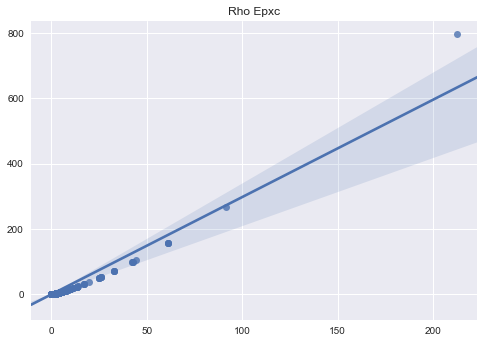

In [23]:
sns.regplot(rho,epxc)

plt.title("Rho Epxc")
plt.show()

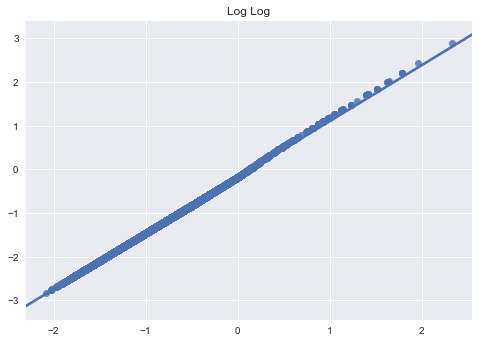

In [24]:
sns.regplot(np.log10(rho),np.log10(epxc))
plt.title("Log Log")
plt.show()

## Log check

In [25]:
log = True

data = np.array([rho,epxc])
if log:
    data = np.log10(data)

## Linear fit residual

In [26]:
def fit_linear(data, mol):
    size = data.shape[1]
    x = data[0].reshape((size,1))
    y = data[1].reshape((size,1))
    
    filename = 'Linear_{}.sav'.format(mol);
    
    li_model = linear_model.LinearRegression()
    li_model.fit(x, y)
    pickle.dump(li_model, open(filename, 'wb'))
    
    # The coefficients
    print ('Coefficients: \n', li_model.coef_)
    # The mean squared error
    print ("Mean squared error: %.20f" % np.mean((li_model.predict(x) - y) ** 2))
    # Explained variance score: 1 is perfect prediction
    print ('Variance score: %.20f' % li_model.score(x, y))
    
    residual = y-li_model.predict(x)
    return np.array(residual)

In [27]:
mol = 'H2O'
residual = np.reshape(fit_linear(data,mol),data.shape[1])
res_data = np.array([rho,residual])

Coefficients: 
 [[ 1.28274486]]
Mean squared error: 0.00008366064199818799
Variance score: 0.99973560349723444851


## Neural Net Ensemble

In [37]:
def fit_nn(x, y, n_layers, n, mol, submodel_no): #can add ranges later
    size = x.shape[0]
    print(size)
    x2 = x.reshape((size,1))
    y2 = y#.reshape((1,size))
    
    fname = 'NN_{}_{}_{}_{}'.format(mol,n,n_layers,submodel_no)
    slowdown_factor = 1
    k = 1
    print (n, k)

    model = Sequential()

    model.add(Dense(output_dim=n, input_dim=1, activation="linear"))

    if n_layers > 1:
        for i in np.arange(n_layers):
            model.add(Dense(input_dim=n, output_dim=n, activation="linear"))
        model.add(Dense(input_dim=n, output_dim=1, activation='linear'))

    # model.add(Dense(input_dim = 1,output_dim =1, activation = 'linear',  init='uniform'))

    print ('model set')
    default_lr = 0.001
    adam = keras.optimizers.Adam(lr=default_lr / slowdown_factor)
    model.compile(loss='mse', optimizer=adam)
    print (model.summary())
    #print (model.get_config())
    
    model.fit(x2, y2, epochs=8, batch_size=1350, verbose = 0)
    scores = model.evaluate(x2,y2)
    
    print (scores)
    
    model_json = model.to_json()
    with open(fname+".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(fname+".h5")
    
    

### Parameters

In [41]:
no_submodels = 8;
n =10;
n_layers = 5;
size_subsample = int(0.632 * data.shape[1]) #1-1/e

### Subsampling and fitting

In [45]:
for submodel_no in tqdm(range(no_submodels)):
    print(submodel_no)
    subsample_mask = np.random.choice(data.shape[1], size_subsample)
    x = data[0,subsample_mask]
    y = data[1,subsample_mask]
    
    fit_nn(x, y,n_layers, n, mol, submodel_no)
    clear_output(wait=True)

100%|██████████| 8/8 [00:50<00:00,  6.17s/it]


## Prediction

In [46]:
def predict_nn(x, n_layers, n, mol, submodel_no):
    fname = 'NN_{}_{}_{}_{}'.format(mol,n,n_layers,submodel_no)
    slowdown_factor = 1
     
    json_file = open(fname+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    
    model.load_weights(fname+".h5")
    print("Loaded model from disk")
    
    default_lr = 0.001
    adam = keras.optimizers.Adam(lr=default_lr / slowdown_factor)
    model.compile(loss='mse', optimizer=adam)
    
    predictions = model.predict(x)
    print(predictions.shape)
    return predictions

### Load models and make predictions

In [47]:
lin_fname = 'Linear_{}.sav'.format(mol);
li_model = pickle.load(open(lin_fname, 'rb'))
predicted_line = np.array(list(map(lambda x: li_model.predict(data[0,x]), np.arange(data.shape[1]))))

predictions = np.zeros((no_submodels, data.shape[1]))
print(predictions[0].shape)

for submodel_no in tqdm(range(no_submodels)):
    subsample_mask = np.random.choice(data.shape[1], size_subsample)
    x = data[0]
    y = data[1]
    predictions[submodel_no] = predict_nn(x, n_layers, n, mol, submodel_no).reshape(data.shape[1])
    clear_output(wait=True)

100%|██████████| 8/8 [00:28<00:00,  3.60s/it]


In [48]:
p2 = np.reshape(np.array(predicted_line),data.shape[1])
p2.shape

data.shape
p2.shape
p2

array([-2.6304597 , -2.56857868, -2.51125015, ..., -2.54208539,
       -2.61374519, -2.68864734])

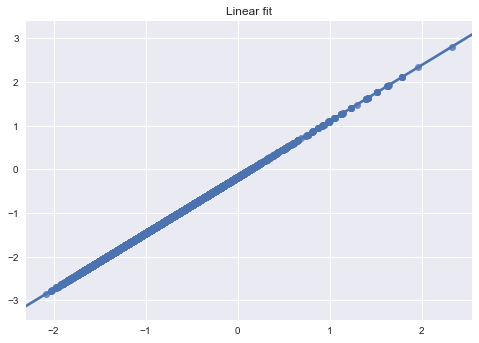

In [49]:
p2 = np.reshape(predicted_line,data.shape[1])
sns.regplot(data[0],p2)
plt.title("Linear fit")
#plt.xlabel('$\rho$')
plt.show()

In [50]:
mu = np.mean(predictions,axis = 0)
sig = np.std(predictions,axis = 0)

pred_data = mu+p2


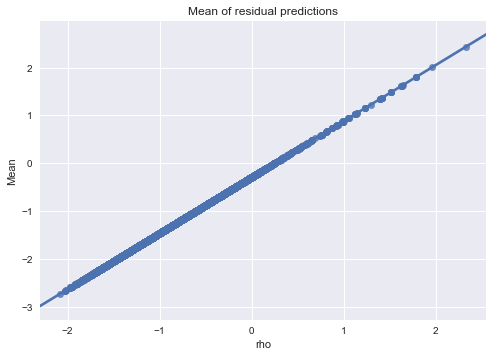

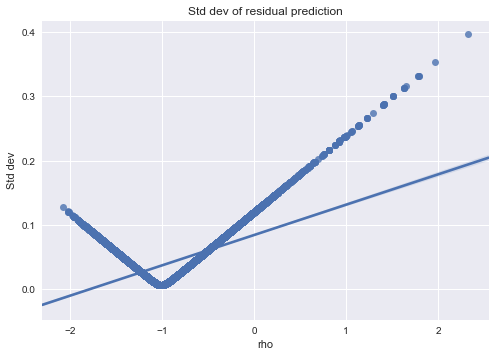

In [51]:
sns.regplot(data[0],mu)
plt.title("Mean of residual predictions")
plt.xlabel('rho')
plt.ylabel('Mean')
plt.show()

sns.regplot(data[0],sig)
plt.xlabel('rho') #$\rho$
plt.ylabel('Std dev')
plt.title("Std dev of residual prediction")
plt.show()

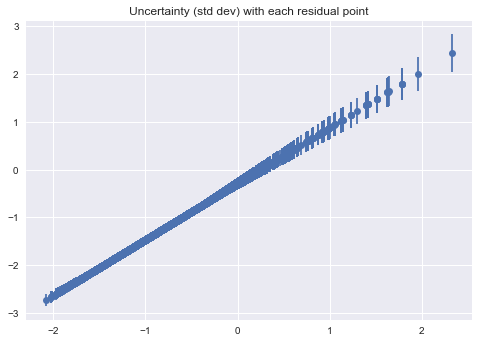

In [52]:
plt.errorbar(data[0], mu, sig, fmt='o')
plt.title('Uncertainty (std dev) with each residual point')
#plt.xlabel('$\rho$')
plt.show()

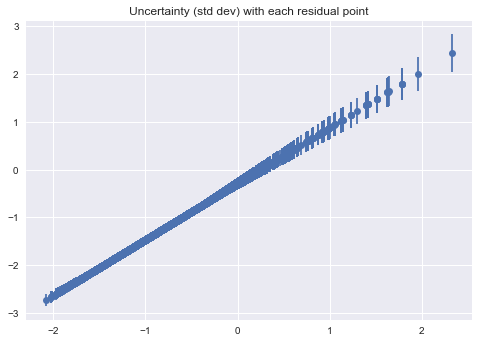

In [53]:
plt.errorbar(data[0], mu, sig, fmt='o')
plt.title('Uncertainty (std dev) with each residual point')
#plt.xlabel('$\rho$')
plt.show()

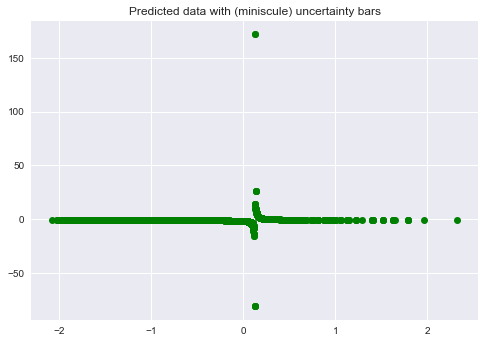

In [54]:
#sig2 = np.std(pred_data,axis = 0)

plt.plot(data[0], (data[1]-pred_data)/data[1],'go')   
plt.title('Predicted data with (miniscule) uncertainty bars')
#plt.xlabel('$\rho$')
plt.show()

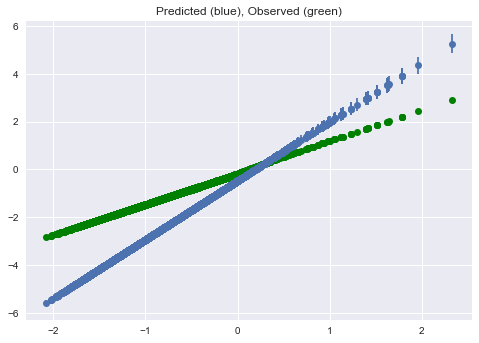

In [55]:
plt.plot(data[0], data[1],'go')       #data[0], pred_data,'bo',
plt.errorbar(data[0], pred_data, sig, fmt='o')
plt.title('Predicted (blue), Observed (green)')
#plt.xlabel('$\rho$')
plt.show()